## Test Task

### Задача:
- виділити групи блогерів так, щоб ці групи якомога більше відрізнялися між
собою.
- описати створені групи блогерів (чому групи розділились і як це можна
використати)
- розробити рекомендаційний алгоритм для замовлення реклами у блогерів з
метою просування продукту компанії

### Опис датасетів:

1) `autors.csv`

- `Author ID` - id автора
- `Name` - назва автора
- `MEIBI` - метрика ідентифікації впливу блогера
- `MEIBIX` - метрика для визначення якості блогу щодо кількості та часу посилань на
коментарі
- `Average Number Of Words In Posts` - середня кількість слів у постах
- `Average Number Of Words In Posts (without stopwords)` - середня кількість слів у постах
без шумових слів

2) `posts.csv`

- `Post ID` - id поста
- `Title` - заголовок
- `Blogger's Name` - ім’я блорега
- `Blogger's ID` - id блогера
- `Number of comments` - кількість коментарів
- `Content` - текст поста
- `Date` - дата створення поста
- `Number of retrieved inlinks` - Кількість отриманих посилань
- `Number of retrieved comments` - Кількість отриманих коментарів

3) `companies.csv`

- `Name` - назва компанії
- `Year Founded` - рік заснування
- `Industry` - тематика компанії
- `Size Range` - величина компанії
- `Country` - країна реєстрації компанії
- `Current Employee Estimate` - сумарна кількість співробітників

### 1. Імпорт бібліотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

### 2. Завантаження даних

In [2]:
def load_data():
    authors_df = pd.read_csv('autors.csv')
    companies_df = pd.read_csv('companies.csv')
    try:
        posts_df = pd.read_csv('posts.csv')
    except FileNotFoundError:
        posts_df = None
    return authors_df, companies_df, posts_df

In [3]:
authors_df, companies_df, posts_df = load_data()

### 3. Огляд даних

In [4]:
def to_snake_case(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False)
    return df

In [5]:
for df in [authors_df, companies_df, posts_df]:
    to_snake_case(df)

In [6]:
def display_data_info(df):
    print("Data shape:", df.shape)
    print(50*"=")
    print(df.dtypes)
    print(50*"=")
    print("\nMissing values in  data:")
    print(df.isnull().sum())
    print(50*"=")
    print(df.head(3))

In [7]:
def make_hist(column, x_title):
    plt.figure(figsize=(6, 3))
    plt.hist(column, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution')
    plt.xlabel(f'{x_title}')
    plt.ylabel('counts')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### authors_df

In [8]:
display_data_info(authors_df)

Data shape: (107, 6)
author_id                                                 int64
name                                                     object
meibi                                                     int64
meibix                                                    int64
average_number_of_words_in_posts_(without_stopwords)    float64
average_number_of_words_in_posts                        float64
dtype: object

Missing values in  data:
author_id                                               0
name                                                    0
meibi                                                   0
meibix                                                  0
average_number_of_words_in_posts_(without_stopwords)    0
average_number_of_words_in_posts                        0
dtype: int64
   author_id               name  meibi  meibix  \
0          1      Jason Kincaid     43      43   
1          2  Michael Arrington    114     114   
2          3    Erick Schonfeld     56      

### companies_df

In [9]:
display_data_info(companies_df)

Data shape: (750, 6)
name                          object
year_founded                 float64
industry                      object
size_range                    object
country                       object
current_employee_estimate      int64
dtype: object

Missing values in  data:
name                           0
year_founded                 379
industry                       0
size_range                     0
country                      229
current_employee_estimate      0
dtype: int64
                         name  year_founded  \
0     blue point technologies           NaN   
1          call a cab limited           NaN   
2  nationwide car hire uk ltd           NaN   

                              industry size_range         country  \
0  information technology and services     1 - 10          greece   
1                   telecommunications     1 - 10  united kingdom   
2     transportation/trucking/railroad     1 - 10             NaN   

   current_employee_estimate  
0        

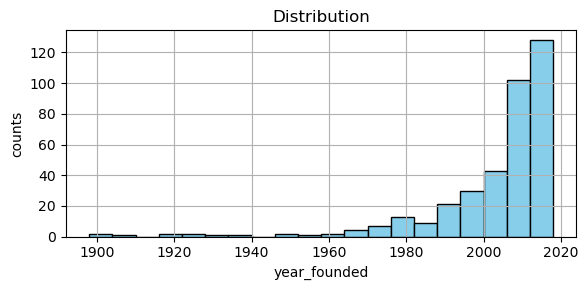

In [10]:
make_hist(companies_df['year_founded'], 'year_founded')

In [11]:
companies_df['year_founded'] = companies_df['year_founded'].fillna(0)

In [12]:
companies_df['country'].unique()

array(['greece', 'united kingdom', nan, 'belgium', 'romania',
       'united states', 'netherlands', 'india', 'italy', 'germany',
       'nigeria', 'spain', 'new zealand', 'slovenia', 'brazil', 'iran',
       'portugal', 'saudi arabia', 'chile', 'australia', 'sweden',
       'colombia', 'canada', 'argentina', 'peru', 'united arab emirates',
       'france', 'lithuania', 'bolivia', 'poland', 'lebanon', 'turkey',
       'switzerland', 'indonesia', 'malaysia', 'mexico', 'ireland',
       'china', 'finland', 'denmark', 'norway', 'venezuela', 'rwanda',
       'isle of man', 'dominican republic', 'singapore', 'egypt', 'japan',
       'austria', 'taiwan', 'pakistan', 'guadeloupe', 'panama'],
      dtype=object)

In [13]:
companies_df['country'] = companies_df['country'].fillna('other')

### posts_df

In [14]:
display_data_info(posts_df)

Data shape: (19464, 9)
post_id                          int64
title                           object
blogger's_name                  object
blogger's_id                     int64
number_of_comments               int64
content                         object
date                            object
number_of_retrieved_inlinks      int64
number_of_retrieved_comments     int64
dtype: object

Missing values in  data:
post_id                          0
title                            5
blogger's_name                   0
blogger's_id                     0
number_of_comments               0
content                         81
date                             0
number_of_retrieved_inlinks      0
number_of_retrieved_comments     0
dtype: int64
   post_id                                              title  \
0        1  We Just Tested Twitter&#8217;s @anywhere Platf...   
1        2  Facebook To Launch &#8216;Relationships&#8217;...   
2        3  NYTimes Request Correction/Removal Of Our Post...  

In [15]:
posts_df[posts_df['title'].isna()]

,post_id,title,blogger's_name,blogger's_id,number_of_comments,content,date,number_of_retrieved_inlinks,number_of_retrieved_comments
6032,6033,NaN,MG Siegler,5,1,You&#8217;d think on a phone that can do as ma...,2009-07-07,0,0
6060,6061,NaN,Sarah Lacy,18,1,Marc Andreessen and Ben Horowitz are launching...,2009-07-05,0,0
6750,6751,NaN,Sarah Lacy,18,1,"Since I got home from China last week, I&#8217...",2009-06-01,0,0
7602,7603,NaN,Sarah Lacy,18,1,Silicon Valley is known for nurturing start-up...,2009-04-19,0,0
13313,13314,NaN,Erick Schonfeld,3,0,"This morning, the New York Post ran a story wi...",2008-03-27,0,0


In [16]:
posts_df.dropna(subset=['title'], inplace=True)

In [17]:
posts_df[posts_df['content'].isna()].head(3)

,post_id,title,blogger's_name,blogger's_id,number_of_comments,content,date,number_of_retrieved_inlinks,number_of_retrieved_comments
3663,3664,Video hilarity: Windows 7 launched on a MacBoo...,Nicholas Deleon,25,193,NaN,2009-10-23,21,109
4393,4394,Plaintiffs In Google Books Settlement Try To D...,Leena Rao,7,5,NaN,2009-09-22,1,3
5358,5359,Video: Where were you when Twitter went down?,Nicholas Deleon,25,55,NaN,2009-08-07,2,46


In [18]:
posts_df.dropna(subset=['content'], inplace=True)

In [19]:
posts_df['date'] = pd.to_datetime(posts_df['date'], errors='coerce')['date'] = pd.to_datetime(posts_df['date'], errors='coerce')
posts_df['year'] = posts_df['date'].dt.year
posts_df['month'] = posts_df['date'].dt.month
posts_df['day'] = posts_df['date'].dt.day

In [20]:
posts_df.drop(columns=['date'], inplace=True)

In [21]:
authors_posts_df = posts_df.merge(authors_df, left_on="blogger's_id", right_on="author_id", how='inner')

In [22]:
authors_posts_df.shape

(19378, 17)

In [23]:
# cols = authors_posts_df.select_dtypes(include='int64').columns
# for col in cols:
#     print(col) 
#     print(f'         max  {authors_posts_df[col].max()}, min  {authors_posts_df[col].min()}')

In [24]:
# cols = authors_posts_df.select_dtypes(include='float64').columns
# for col in cols:
#     print(col) 
#     print(f'         max  {authors_posts_df[col].max()}, min  {authors_posts_df[col].min()}')

In [25]:
def convert_dtypes(df):
    before = df.memory_usage(deep=True).sum()

    int_cols = df.select_dtypes(include='int64').columns
    for col in int_cols:
        df[col] = df[col].astype('int16')
    
    float_cols = df.select_dtypes(include='float64').columns
    df[float_cols] = df[float_cols].astype('float16')
    
    after = df.memory_usage(deep=True).sum()
    print(f"Memory reduced from {before/1e6:.2f} MB to {after/1e6:.2f} MB")
    return df

In [26]:
authors_posts_df = convert_dtypes(authors_posts_df)

Memory reduced from 69.69 MB to 68.53 MB


In [27]:
companies_df = convert_dtypes(companies_df)

Memory reduced from 0.23 MB to 0.22 MB


In [28]:
authors_posts_df.columns

Index(['post_id', 'title', 'blogger's_name', 'blogger's_id',
       'number_of_comments', 'content', 'number_of_retrieved_inlinks',
       'number_of_retrieved_comments', 'year', 'month', 'day', 'author_id',
       'name', 'meibi', 'meibix',
       'average_number_of_words_in_posts_(without_stopwords)',
       'average_number_of_words_in_posts'],
      dtype='object')

### 4. Підготовка фіч для кластеризації

In [29]:
def prepare_clustering_features(df):
    df['word_efficiency'] = (
        df['average_number_of_words_in_posts_(without_stopwords)'] / 
        df['average_number_of_words_in_posts']
    )
    df['influence_quality_ratio'] = df['meibi'] / df['meibix']
    df['influence_quality_ratio'].fillna(0, inplace=True)
    features = [
        'meibi',
        'meibix',
        'average_number_of_words_in_posts_(without_stopwords)',
        'average_number_of_words_in_posts',
        'word_efficiency',
        'influence_quality_ratio'
    ]

    return df, features

In [30]:
authors_posts_df, features = prepare_clustering_features(authors_posts_df)

### 5. Кластеризація (KMeans + вибір оптимального k)

In [31]:
def perform_clustering(df, features, k_range=(2,8)):
    scaler = StandardScaler()
    X = df[features].values
    X_scaled = scaler.fit_transform(X)
    
    silhouette_scores = []
    inertias = []
    
    for k in range(k_range[0], k_range[1]+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        inertias.append(kmeans.inertia_)
    
    optimal_k = range(k_range[0], k_range[1]+1)[np.argmax(silhouette_scores)]
    print(f"Optimal k: {optimal_k}, silhouette score: {max(silhouette_scores):.3f}")
    
    final_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_model.fit_predict(X_scaled)
    df['Cluster'] = cluster_labels
    
    return df, final_model, X_scaled, cluster_labels, features

In [32]:
authors_posts_df.isna().sum()

post_id                                                 0
title                                                   0
blogger's_name                                          0
blogger's_id                                            0
number_of_comments                                      0
content                                                 0
number_of_retrieved_inlinks                             0
number_of_retrieved_comments                            0
year                                                    0
month                                                   0
day                                                     0
author_id                                               0
name                                                    0
meibi                                                   0
meibix                                                  0
average_number_of_words_in_posts_(without_stopwords)    0
average_number_of_words_in_posts                        0
word_efficienc

In [33]:
df, kmeans_model, X_scaled, cluster_labels, features = perform_clustering(authors_posts_df, features)

Optimal k: 8, silhouette score: 0.709


### 6. Візуалізація кластерів

In [34]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd

def visualize_clusters(df, X_scaled, cluster_labels, features):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(15, 10))
    
    # 1. Кластери у PCA-просторі
    plt.subplot(2, 3, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.title('Blogger Clusters (PCA)')
    plt.colorbar(scatter)
    
    # 2. MEIBI vs MEIBIX
    plt.subplot(2, 3, 2)
    plt.scatter(df['meibi'], df['meibix'], c=cluster_labels, cmap='viridis')
    plt.xlabel('MEIBI')
    plt.ylabel('MEIBIX')
    plt.title('Influence vs Quality')
    
    # 3. Середня довжина поста vs ефективність
    plt.subplot(2, 3, 3)
    plt.scatter(df['average_number_of_words_in_posts'], df['word_efficiency'], c=cluster_labels, cmap='viridis')
    plt.xlabel('Average Words per Post')
    plt.ylabel('Word Efficiency')
    plt.title('Content Metrics')
    
    # 4. Розподіл по кластерах
    plt.subplot(2, 3, 4)
    counts = pd.Series(cluster_labels).value_counts().sort_index()
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Bloggers')
    plt.title('Cluster Size Distribution')
    
    # 5. Важливість ознак у PCA
    plt.subplot(2, 3, 5)
    comp_df = pd.DataFrame(pca.components_.T, index=features, columns=['PC1', 'PC2'])
    comp_df.plot(kind='bar', ax=plt.gca())
    plt.title('PCA Feature Importance')
    plt.xticks(rotation=45)
    
    # 6. Дендограмa
    plt.subplot(2, 3, 6)
    linkage_matrix = linkage(X_scaled, method='ward')
    dendrogram(linkage_matrix, truncate_mode='lastp', p=20)
    plt.title('Hierarchical Clustering Dendrogram')
    
    plt.tight_layout()
    plt.show()


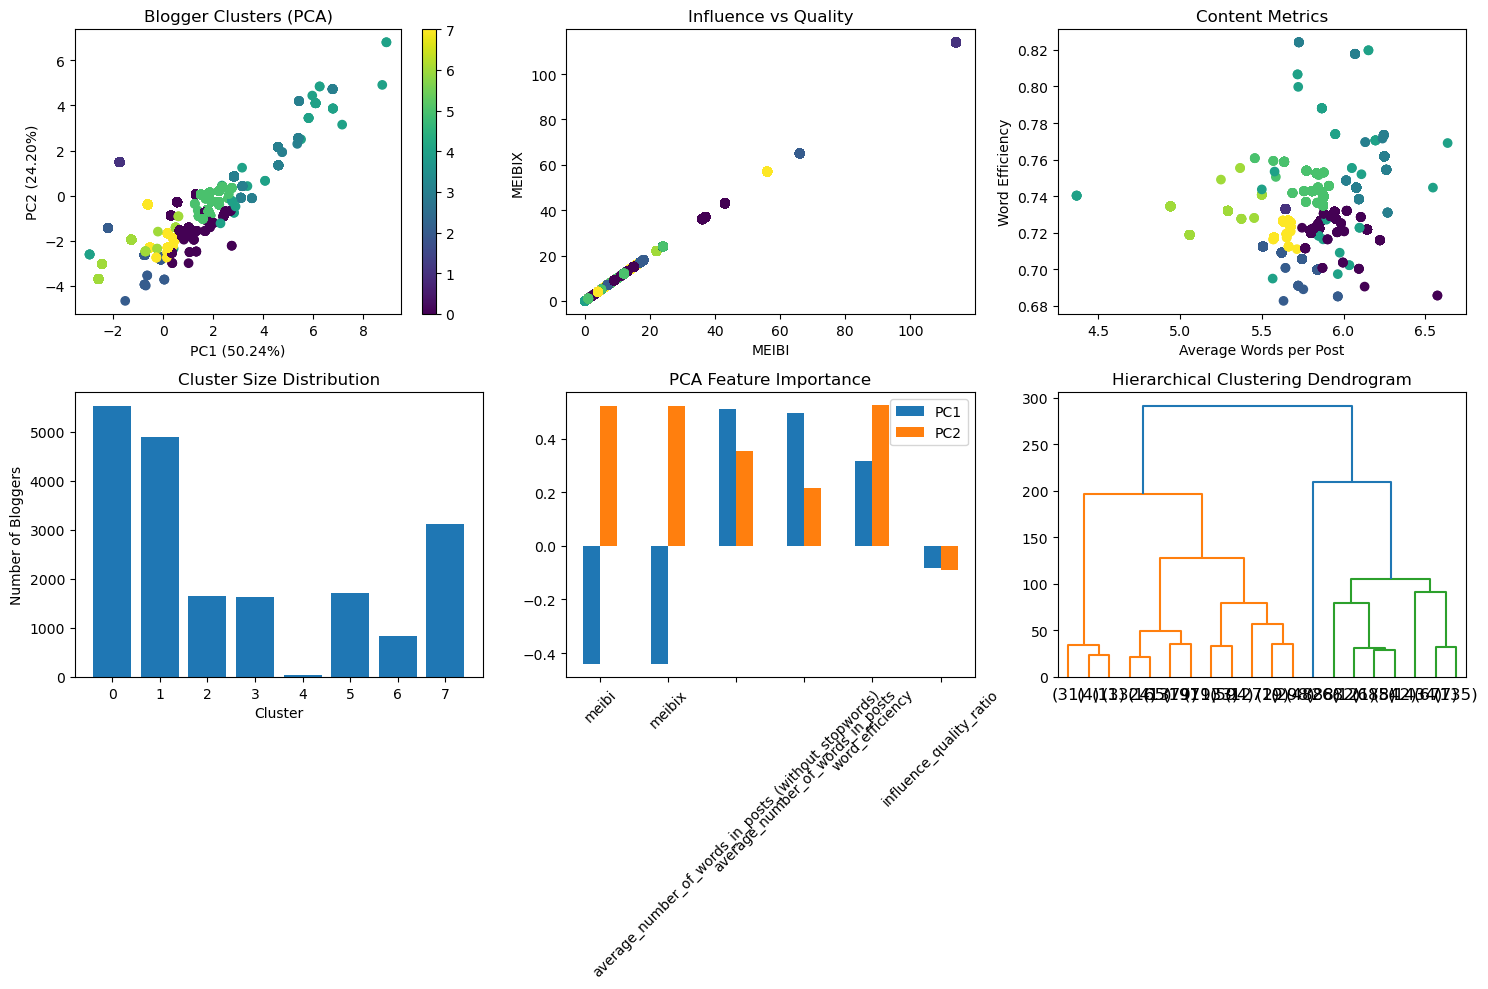

In [35]:
visualize_clusters(df, X_scaled, cluster_labels, features)

### 7. Аналіз кластерів (приклад)

In [36]:
def analyze_clusters(df):
    n_clusters = df['Cluster'].nunique()
    overall_meibi = df['meibi'].mean()
    overall_meibix = df['meibix'].mean()
    overall_words = df['average_number_of_words_in_posts'].mean()
    
    cluster_profiles = {}
    for cluster in range(n_clusters):
        cluster_df = df[df['Cluster'] == cluster]
        avg_meibi = cluster_df['meibi'].mean()
        avg_meibix = cluster_df['meibix'].mean()
        avg_words = cluster_df['average_number_of_words_in_posts'].mean()
        word_efficiency = (
            cluster_df['average_number_of_words_in_posts_(without_stopwords)'] /
            cluster_df['average_number_of_words_in_posts']
        ).mean()
        
        # Визначення типу кластера
        if avg_meibi > overall_meibi * 1.5 and avg_meibix > overall_meibix * 1.5:
            ctype = "Top Influencers"
        elif avg_meibi > overall_meibi and avg_words > overall_words * 1.2:
            ctype = "Content Creators"
        elif word_efficiency > 0.75 and avg_words < overall_words:
            ctype = "Micro-Influencers"
        elif avg_meibix > avg_meibi:
            ctype = "Quality Focused"
        else:
            ctype = "Emerging Influencers"
        
        cluster_profiles[cluster] = {
            'type': ctype,
            'size': len(cluster_df),
            'avg_meibi': avg_meibi,
            'avg_meibix': avg_meibix,
            'avg_words': avg_words,
            'word_efficiency': word_efficiency,
            'sample_names': list(cluster_df['name'].head(3))
        }
        
        print(f"\nCluster {cluster}: {ctype}, size = {len(cluster_df)}")
        print(f"Sample bloggers: {cluster_profiles[cluster]['sample_names']}")
    
    return cluster_profiles

In [37]:
cluster_profiles = analyze_clusters(df)


Cluster 0: Emerging Influencers, size = 5523
Sample bloggers: ['Jason Kincaid', 'Jason Kincaid', 'Jason Kincaid']

Cluster 1: Top Influencers, size = 4888
Sample bloggers: ['Michael Arrington', 'Michael Arrington', 'Michael Arrington']

Cluster 2: Emerging Influencers, size = 1643
Sample bloggers: ['MG Siegler', 'MG Siegler', 'MG Siegler']

Cluster 3: Emerging Influencers, size = 1626
Sample bloggers: ['Leena Rao', 'Leena Rao', 'Leena Rao']

Cluster 4: Micro-Influencers, size = 48
Sample bloggers: ['Arden Pennell', 'Arden Pennell', 'Roxanne Varza']

Cluster 5: Emerging Influencers, size = 1714
Sample bloggers: ['Mike Butcher', 'Mike Butcher', 'Mike Butcher']

Cluster 6: Emerging Influencers, size = 825
Sample bloggers: ['John Biggs', 'John Biggs', 'John Biggs']

Cluster 7: Quality Focused, size = 3111
Sample bloggers: ['Erick Schonfeld', 'Erick Schonfeld', 'Erick Schonfeld']


### 8. Підготовка даних компаній

In [40]:
# def prepare_companies(companies_df, bloggers_df):
#     agg_metrics = bloggers_df.groupby('company_name').agg({
#         'meibi': 'mean',
#         'meibix': 'mean',
#         'average_number_of_words_in_posts': 'mean'
#     }).rename(columns={
#         'meibi': 'mean_influence',
#         'meibix': 'mean_quality',
#         'average_number_of_words_in_posts': 'mean_words'
#     }).reset_index()
    

#     companies_df = companies_df.merge(agg_metrics, left_on='name', right_on='company_name', how='left')
    
#     companies_df[['mean_influence', 'mean_quality', 'mean_words']] = companies_df[[
#         'mean_influence', 'mean_quality', 'mean_words'
#     ]].fillna(0)
    
#     return companies_df

In [42]:
# companies_df = prepare_companies(companies_df, df)

In [45]:
# companies_df[['mean_influence', 	'mean_quality', 	'mean_words']].sum()

mean_influence    0.0
mean_quality      0.0
mean_words        0.0
dtype: float64

### 9. Рекомендації блогерів для компаній (на основі найближчих кластерів)

In [65]:
companies_df.columns

Index(['name', 'year_founded', 'industry', 'size_range', 'country',
       'current_employee_estimate'],
      dtype='object')

In [66]:
df.columns

Index(['post_id', 'title', 'blogger's_name', 'blogger's_id',
       'number_of_comments', 'content', 'number_of_retrieved_inlinks',
       'number_of_retrieved_comments', 'year', 'month', 'day', 'author_id',
       'name', 'meibi', 'meibix',
       'average_number_of_words_in_posts_(without_stopwords)',
       'average_number_of_words_in_posts', 'word_efficiency',
       'influence_quality_ratio', 'Cluster'],
      dtype='object')

In [46]:
def recommend_bloggers_for_companies(companies_df, bloggers_df, cluster_profiles, n_recommendations=3):
    recommendations = {}
    
    for _, row in companies_df.iterrows():
        company_name = row['name']
        
        # Визначаємо найбільш відповідний кластер
        best_cluster = None
        best_score = -np.inf
        
        for cluster, profile in cluster_profiles.items():
            score = -abs(row['mean_influence'] - profile['avg_meibi']) \
                    -abs(row['mean_quality'] - profile['avg_meibix']) \
                    -abs(row['mean_words'] - profile['avg_words'])
            
            if score > best_score:
                best_score = score
                best_cluster = cluster
        
        # Отримуємо блогерів із найкращого кластера
        cluster_bloggers = bloggers_df[bloggers_df['Cluster'] == best_cluster]
        
        # Обираємо топ-n за MEIBI
        top_bloggers = cluster_bloggers.sort_values(by='meibi', ascending=False).head(n_recommendations)
        
        recommendations[company_name] = list(zip(top_bloggers['name'], top_bloggers['meibi']))
    
    return recommendations

### 10. Приклад запуску всього пайплайна

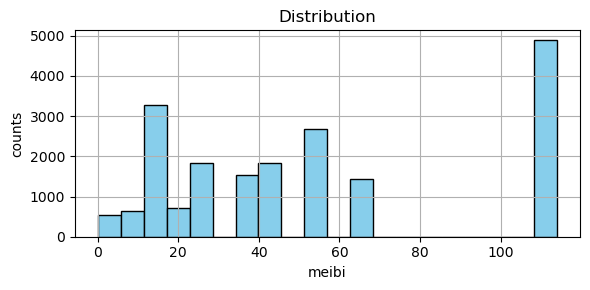

In [50]:
make_hist(df['meibi'], 'meibi')

In [53]:
recs = recommend_bloggers_for_companies(companies_df, df, cluster_profiles)

In [60]:
recs_df = pd.DataFrame(recs).T

In [61]:
recs_df

,0,1,2
blue point technologies,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
call a cab limited,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
nationwide car hire uk ltd,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
european biomass association,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
intermedicas worldwide,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
...,...,...,...
machinefabriek rotterdam,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
"gazmar, s.l.","(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
power consulting group,"(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
"spalding tougias architects, inc.","(Arden Pennell, 0)","(Arden Pennell, 0)","(Stefano Bernardi, 0)"
